Vitória Rodrigues Pinto Borelli Figueiredo - RA: 800203



---

# **Trabalho 4 - Inteligência Artificial**
**Aprendizado de Máquina Não Supervisionado**
--

---

##Introdução

Este trabalho consiste na execução do algoritmo de aprendizado não supervisionado para agrupamento (k-means) estudado na disciplina e para definição do melhor número de grupos usando o método do “cotovelo”, usando a biblioteca sklearn (https://scikit-learn.org/stable/index.html). As etapas são descritas detalhadamente a seguir e, abaixo, encontram-se as importações das bibliotecas utilizadas para o desenvolvimento.


In [1]:
# leitura dos dados e manipulação do dataframe
import pandas as pd

# pré-processamento, normalização dos dados
from sklearn.preprocessing import MinMaxScaler

# algoritmo k-means
from sklearn.cluster import KMeans

# validação do agrupamento, índices ARI e AMI e silhueta
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
from sklearn.metrics import silhouette_score

# método do cotovelo, determinação da melhor quantidade de clusters
from yellowbrick.cluster import KElbowVisualizer

# plotagem dos gráficos dos índices de erro quadrático e silhueta, assim como a respectiva aplicação visual do método do cotovelo
import matplotlib.pyplot as plt

## Seleção e Leitura do Dataset

Nesta etapa, foi selecionado um conjunto de dados rotulados, permitindo que seja feita a validação externa através das classes após o agrupamento. Vale ressaltar que, para realização do agrupamento propriamente dito, as classes são retiradas, mantendo os princípios do aprendizado de máquina não supervisionado. Em seguida, o conjunto de dados foi lido no formato .csv com a função *read_csv(...)* (biblioteca Pandas);

O dataset escolhido para análise trata-se da **clusterização de estrelas**, separando-as em categorias de acordo com suas características físicas como tamanho, temperatura e cor. Os dados podem ser acessados a partir do link: https://www.kaggle.com/datasets/brsdincer/star-type-classification


In [2]:
data = pd.read_csv('/content/Stars.csv')

In [3]:
# aspecto geral dos dados
data

,Temperature,L,R,A_M,Color,Spectral_Class,Type
0,3068,0.002400,0.1700,16.12,Red,M,0
1,3042,0.000500,0.1542,16.60,Red,M,0
2,2600,0.000300,0.1020,18.70,Red,M,0
3,2800,0.000200,0.1600,16.65,Red,M,0
4,1939,0.000138,0.1030,20.06,Red,M,0
...,...,...,...,...,...,...,...
235,38940,374830.000000,1356.0000,-9.93,Blue,O,5
236,30839,834042.000000,1194.0000,-10.63,Blue,O,5
237,8829,537493.000000,1423.0000,-10.73,White,A,5
238,9235,404940.000000,1112.0000,-11.23,White,A,5


In [4]:
data.columns

Index(['Temperature', 'L', 'R', 'A_M', 'Color', 'Spectral_Class', 'Type'], dtype='object')

Apenas para permitir maior compreensão do dataset, são explicados cada um de seus argumentos:

* **Temperature:** temperatura superficial absoluta (em K) da estrela.
* **L:** luminosidade relativa, calculada por L/Lo (onde Lo = 3.828 x 10^26 Watts, luminosidade média do sol).
* **R:** raio relativo, calculado por R/Ro (onde Ro = 6.9551 x 10^8 m, raio médio do sol).
* **A_M:** magnitude absoluta.
* **Color:** cor da estrela, podendo variar entre White, Blue, Red, Yellow, etc.
* **Spectral_Class:** relativo à sua radiação e características espectrais, podendo variar entre O, B, A, F, M, etc.
* **Type:** classe alvo do conjunto de dados, no dataset, é representada por 6 classes, nomeadas a seguir.
  * 0: Brown Dwarf
  * 1: Red Dwarf
  * 2: White Dwarf
  * 3: Main Sequence
  * 4: Supergiant
  * 5: Hypergiant


De forma geral, o agrupamento deve ser dado como algo parecido com a imagem a seguir.


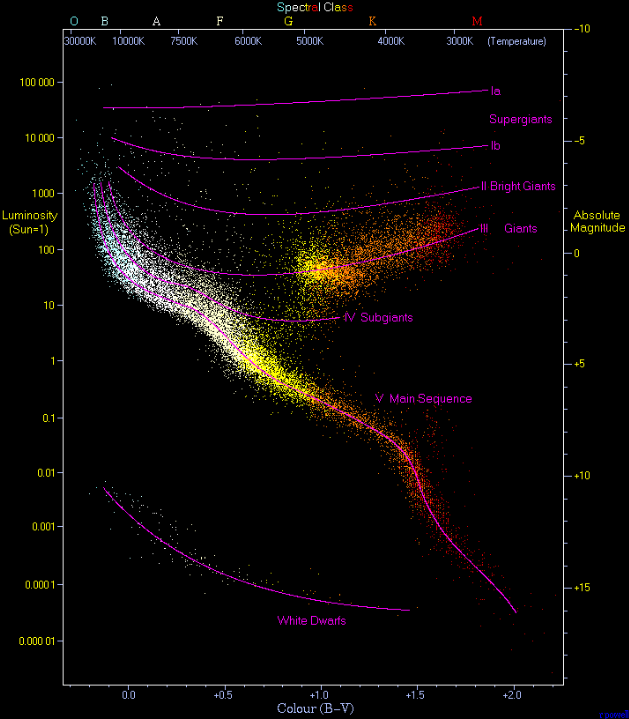


## Formatação dos Dados


Nesta etapa, é realizada a separação dos atributos meta (classes) do resto do conjunto, sendo usado posteriormente apenas como validação externa, de modo que ambos fiquem num formato de uso aplicável para os algoritmos.

Primeiramente, foi feita a busca por valores ausentes que deveriam ser tratados.

In [5]:
data.isna().sum()

Temperature       0
L                 0
R                 0
A_M               0
Color             0
Spectral_Class    0
Type              0
dtype: int64

Felizmente, todos os atributos dos 240 de exemplos do dataset estão preenchidos e não deverão ser feitos tratamentos nesse quesito. A seguir foi realizada a formatação dos dados propriamente dita, criação de uma nova tabela *stars* sem a classe.


In [6]:
# vetor de classes
target = data['Type']

# matriz de atributos
stars = data.drop(columns = ['Type'], axis = 1)

## Transformação dos Dados

Nesta seção, serão transformados os atributos nominais em binários com a função *get_dummies()*, visto que a implementação do algoritmo k-means do scikit-learn não aceita atributos categóricos, assim como tambem será feita a normalização dos atributos contínuos com a função *fit()* da classe *MinMaxScaler* (todas as bibliotecas utilizadas foram importadas no início do notebook).

### Categóricos ➡ Binários


In [7]:
# dividindo a lista de atributos entre categóricos e contínuos

categorical = ['Color', 'Spectral_Class']
continuous = ['Temperature', 'L', 'R', 'A_M']

# transformação dos catégóricos em binários
for col in categorical:
    dummies = pd.get_dummies(stars[col], prefix=col)
    stars = pd.concat([stars, dummies], axis=1)
    stars.drop(col, axis=1, inplace=True)

# visualização do estado atual da tabela
stars.head()

,Temperature,L,R,A_M,Color_Blue,Color_Blue White,Color_Blue white,Color_Blue-White,Color_Blue-white,Color_Orange,...,Color_white,Color_yellow-white,Color_yellowish,Spectral_Class_A,Spectral_Class_B,Spectral_Class_F,Spectral_Class_G,Spectral_Class_K,Spectral_Class_M,Spectral_Class_O
0,3068,0.002400,0.1700,16.12,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,3042,0.000500,0.1542,16.60,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,2600,0.000300,0.1020,18.70,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,2800,0.000200,0.1600,16.65,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,1939,0.000138,0.1030,20.06,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


Nota-se a criação de várias novas colunas, uma para cada possibilidade de categoria que cada atributo pode assumir. A seguir, é feita a normalização de 0 a 1 dos atributos contínuos para se adequarem ao algoritmo.

### Normalização

In [8]:
# criação uma instância do MinMaxScaler
mms = MinMaxScaler()

# ajustando o scaler aos dados
mms.fit(stars)

# transformando os dados com o scaler (ajustado)
stars_transformed = mms.transform(stars)

# convertendo a matriz resultante para o formato DataFrame novamente
stars_transformed = pd.DataFrame(stars_transformed)

# visualização do conjunto de dados transformado
stars_transformed.head()

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,0.029663,2.731275e-09,0.000083,0.876798,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.028980,4.944550e-10,0.000075,0.891807,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.017367,2.590003e-10,0.000048,0.957473,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.022622,1.412729e-10,0.000078,0.893371,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.000000,6.828189e-11,0.000049,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## Aplicação do Algoritmo (quantidade fixa de grupos)

Neste etapa é aplicado o algoritmo k-means no conjunto de dados transformado, definindo o número de clusters resultante como o número de classes do dataset original (6).

In [9]:
# definição do número de grupos (= número de classes)
group_amount = len(target.unique())

# aplicação do k-means, utilizando os dados transformados como treinamento
kmeans = KMeans(n_clusters=group_amount, random_state=21)
kmeans.fit(stars_transformed)

# salvando as informações de cluster na variável stars_clusters
stars_clusters = kmeans.labels_

# visualização prévia do resultado (em formato vetor)
print("Clusters Previstos: \n")
print(stars_clusters)

print("\nClusters Reais: \n")
print(target.values)

Clusters Previstos: 

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 5 2 2 2 5 2 2 2 2 2 1 3 3 5 2 2 2
 2 2 2 4 4 4 4 4 4 4 4 4 5 4 4 4 4 4 4 4 4 4 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 2 2 2 5 5 2 5 5 2 5 2 2 2 2 3 3 2 2 3 1 5 1 1 1 1 1 1 1 1 1 4
 4 4 4 4 4 4 4 4 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 5 5 5 5 5 2 5 2
 2 5 3 2 3 3 3 3 3 3 3 1 1 1 1 1 1 1 1 1 1 1 4 4 2 5 4 4 1 3 3 3 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 5 5 5 5 5 5 5 5 5 5 3 3 3 3 1 1 3 3 3 2 1 1
 1 1 1 1 1 1 1 1 3 1 1 3 3 1 1 2 2 1]

Clusters Reais: 

[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3
 3 3 3 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 0 0 0 0 0 0 0 0 0 0 1 1 1 1
 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 5
 5 5 5 5 5 5 5 5 5 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2
 2 2 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 0 0 0 0 0
 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 4 4
 4 4 4 4 4 4 4 4 5 5 

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


## Validação (Índices ARI e AMI)

Aplicação dos índices de validação ARI (Adjusted Rand Index) e AMI (Adjusted Mutual Information) usando as funções disponíveis na biblioteca scikit-learn para avaliar o agrupamento resultante.


In [10]:
# cálculo dos índices, comparando o resultado com o target separado do dataset original
ari = adjusted_rand_score(target, stars_clusters)
ami = adjusted_mutual_info_score(target, stars_clusters)

# visualização dos resultados
print(f"Adjusted Rand Index (ARI): {ari}")
print(f"Adjusted Mutual Information (AMI): {ami}")

Adjusted Rand Index (ARI): 0.48574230903917814
Adjusted Mutual Information (AMI): 0.616919960192916


Os dois índices apresentados são métricas de avaliação de agrupamentos que comparam os agrupamentos reais (verdadeiros) com os agrupamentos previstos pelo modelo. A diferença entre eles reside basicamente na forma como medem a semelhança entre agrupamentos e como lidam com o acaso. Isso se dá pois o ARI incorpora o conceito de correspondência bruta, que mede diretamente a concordância entre os agrupamentos reais e previstos em termos de pares de amostras, considerando os verdadeiros positivos e negativos. Por outro lado, o AMI incorpora o conceito de informação mútua, medindo a quantidade de informação que os dois agrupamentos compartilham baseando-se no conceito de entropia (medida de desordem).

Dessa forma, temos que os dois índices sugerem correspondência moderada entre os agrupamentos reais e previstos. Valores próximos de 1 indicam uma correspondência forte, então os valores 0.486 e 0.617 encontrados indicam que há alguma similaridade, mas não é uma correspondência perfeita.

O fato do índice AMI ter valores superiores pode sugerir, visto as explicações anteriores, que há uma correspondência mais forte em termos de informação mútua do que a correspondência bruta entre os pares avaliados. De forma geral, pode-se entender que, apesar de algumas diferenças nos rótulos de cluster entre os agrupamentos reais e previstos (o que seria refletido na correspondência bruta, como medida pelo ARI), há uma quantidade significativa de padrões compartilhados entre esses agrupamentos, conforme capturado pela informação mútua (AMI).

## Aplicação do Algoritmo (quantidade variável de grupos) + Coleta da Inércia e da Silhueta

Neste etapa, ao invés da utilização da quantidade de grupos já conhecida (o que não faria sentido em casos reais), será definido um intervalo de valores para número de grupos (por exemplo, de 2 a 15, ou um intervalo maior caso seja necessário para visualizar a variação do índice no gráfico). Posteriormente, tais valores serão analisados para definir qual quantidade gerou os melhores resultados.

Em seguida, foi aplicado novamente o algoritmo k-means no conjunto de dados (sem a classe) para cada um dos valores do intervalo definido usando a classe *KMeans* e a função *fit()*.

Neste mesmo laço, foram coletados os valores do **índice soma quadrática das distâncias** para todos os agrupamentos encontrados, usando o atributo *inertia_* da classe *KMeans*, e o **índice de validação silhueta**, usando a função da biblioteca scikit-learn. Ambos os índices, assim como seus resultados, serão melhor apresentados em suas seções de visualização.

In [11]:
# definindo o intervalo de valores de número de cluster
num_clusters_range = range(2, 16)

# armazenamento dos reesultados de erro quadrático e silhueta
inertia_values = []
silhouette_scores = []

# aplicando k-means para todos os valores do intervalo
for num_clusters in num_clusters_range:
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(stars_transformed)

    # coletando valores de erro quadrático
    error = kmeans.inertia_
    inertia_values.append(error)

    # coletando valores silhueta
    silhouette = silhouette_score(stars_transformed, kmeans.predict(stars_transformed))
    silhouette_scores.append(silhouette)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

## Plotagem da Inércia e Método do Cotovelo

Nessa seção, será plotado o gráfico com os índices de erro quadrático para cada quantidade de clusters e, nele, será aplicado o método do cotovelo para determinar qual quantidade é ideal para o modelo.

Inicialmente, é válida uma apresentação acerca do índice de erro quadrático. É uma métrica aplicada para cada ponto de um conjunto de dados, calculando a distância ao quadrado entre ele e o centróide do cluster ao qual pertence. A soma dessa distância para todos os pontos de todos os clusters resulta no valor final de erro quadrático.

Assim, temos que, quanto menor o valor encontrado, mais próximos de cada centróide os pontos estão, sugerindo clusters compactos e homogêneos.

Com os resultados de índice obtidos para cada ponto, foi plotado um gráfico que tende a diminuir conforme o aumento da quantidade de clusters. Isso se dá pois, quanto mais clusters, maior a especificação, ou seja, mais específicos os exemplos pertencentes a ele. No entanto, alcança-se um ponto que a divisão de clusters deixa de fazer tanta diferença para o resultado final, gerando apenas complicações como overfitting (classificações muito específicas aos exemplos treinados, não sendo capazes de generalizar um comportamento para futuros exemplos) e redundância entre os clusters.

É nesse quesito que o método do cotovelo se aplica, encontrando tal ponto de equilíbrio no gráfico, como será mostrado abaixo.

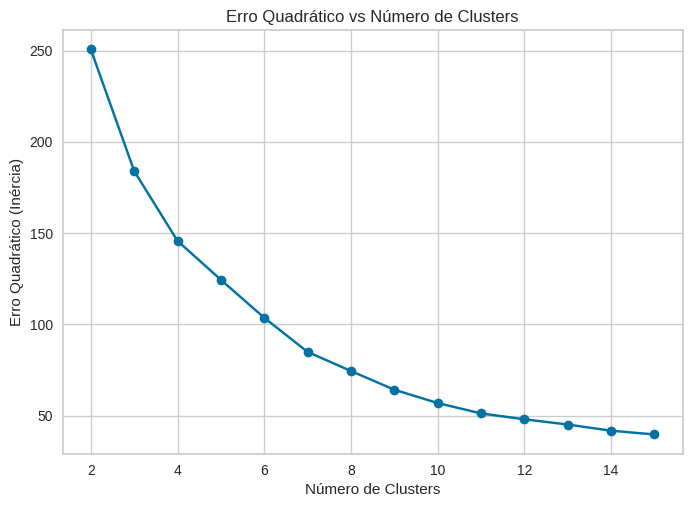

In [12]:
# visualização de erro quadrático (inércia) vs quantidade de clusters
plt.plot(num_clusters_range, inertia_values, marker='o')
plt.title('Erro Quadrático vs Número de Clusters')
plt.xlabel('Número de Clusters')
plt.ylabel('Erro Quadrático (Inércia)')
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

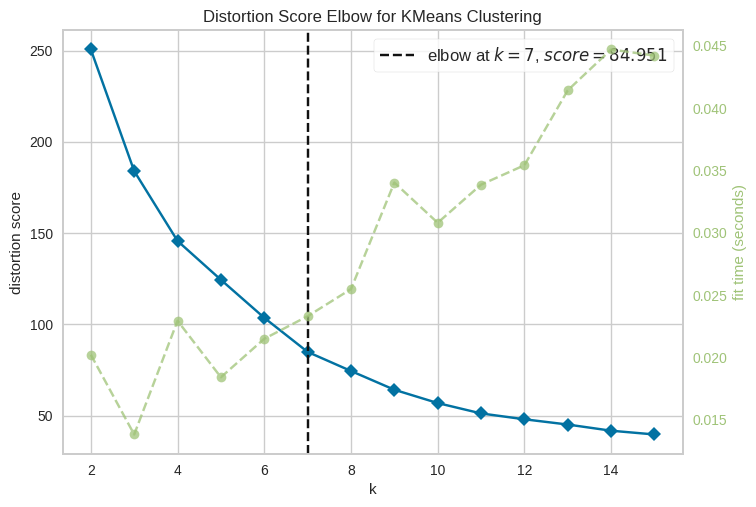

In [13]:
# aplicação do método do cotovelo
model = KMeans(random_state=42)
visualizer = KElbowVisualizer(model, k=(2, 16))
visualizer.fit(stars_transformed)
visualizer.show();

Assim, temos que o método do cotovelo aplicado ao índice de erro quadrático indica a quantidade ideal de clusters como 7.

O resultado obtido é satisfatório visto a quantidade real (6 categorias). O motivo de gerar divisões a mais pode recair sobre a captura de variações ou nuances que não correspondem necessariamente a uma estrutura propriamente dita dos dados.

## Plotagem dos Índices de Silhueta e Método do Cotovelo

Nessa seção, será plotado o gráfico com os índices de silhueta para cada quantidade de clusters e, nele, será aplicado o método do cotovelo para determinar qual quantidade é ideal para o modelo.

Inicialmente, é válida uma apresentação acerca do índice de silhueta. Ele é uma métrica que avalia a qualidade dos agrupamentos em um conjunto de dados, fornecendo uma medida de quão semelhantes são os objetos dentro de um cluster em comparação com os objetos nos clusters vizinhos. O índice da silhueta varia de -1 a 1, onde um valor próximo de 1 indica que o objeto está bem dentro do seu próprio cluster e distante de outros clusters, um valor de 0 indica que o objeto está na fronteira entre dois clusters e próximo de -1 indica que o objeto pode ter sido atribuído ao cluster errado.

O cálculo do índice de silhueta é realizado para cada ponto de dados e é uma média dos valores de silhueta para todos os pontos no conjunto de dados. Dessa forma, quanto mais próxima de 1, mais bem separados um dos outros e coesos entre si estão os clusters.

Com os resultados de índice obtidos para cada ponto, foi plotado o gráfico e, nele, aplicado o método do cotovelo tal qual foi realizado com a inércia.

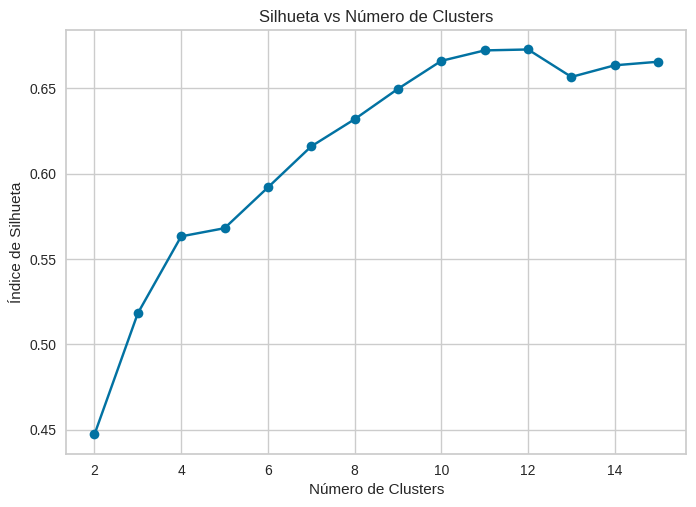

In [14]:
# visualização de silhueta vs quantidade de clusters
plt.plot(num_clusters_range, silhouette_scores, marker='o')
plt.title('Silhueta vs Número de Clusters')
plt.xlabel('Número de Clusters')
plt.ylabel('Índice de Silhueta')
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

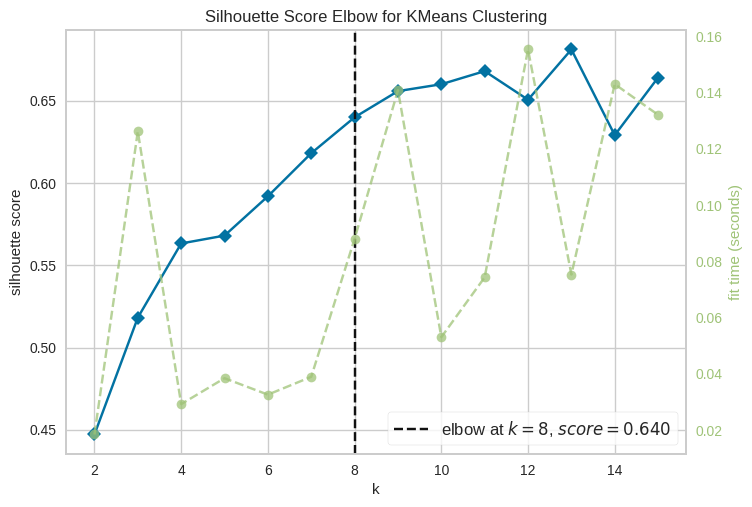

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [17]:
# aplicação do método do cotovelo
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2, 16), metric='silhouette')
visualizer.fit(stars_transformed)
visualizer.show()

Com este método foi possível encontrar a quantidade de clusters sugeridas como 8. Dado que o valor real seria 6, o índice de erro quadrático se mostrou mais preciso.

Assim como para inércia, o método do cotovelo continua sensível a variações nos dados ou nuances específicas, podendo encontrar padrões em divisões de uma mesma categoria original.

De qualquer forma, o resultado obtido é relativamente próximo ao esperado e também mostra-se satisfatório.


## Conclusão

Este trabalho permitiu aplicação, validação e melhor compreensão a respeito de tópicos chave do aprendizado de máquina não supervisionado, tais como algoritmo k-means, índices ARI, AMI, erro quadrático e de silhueta e método do cotovelo.

Assim, tem-se que os algoritmos e métodos utilizados se mostraram eficientes para o objetivo do estudo, agrupar estrelas e decidir sua quantidade ideal de clusters.